In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

# Define the date range
start_date = '2021-01-01'
end_date = '2023-12-31'

# Fetch historical data for ETH/USDT from Yahoo Finance
eth_usdt = yf.download('ETH-USD', start=start_date, end=end_date)

# Display the first few rows of the raw data
print("Raw Data:")
print(eth_usdt.head())

[*********************100%%**********************]  1 of 1 completed

Raw Data:
                   Open         High         Low        Close    Adj Close  \
Date                                                                         
2021-01-01   737.708374   749.201843  719.792236   730.367554   730.367554   
2021-01-02   730.402649   786.798462  718.109497   774.534973   774.534973   
2021-01-03   774.511841  1006.565002  771.561646   975.507690   975.507690   
2021-01-04   977.058838  1153.189209  912.305359  1040.233032  1040.233032   
2021-01-05  1041.498779  1129.371460  986.811279  1100.006104  1100.006104   

                 Volume  
Date                     
2021-01-01  13652004358  
2021-01-02  19740771179  
2021-01-03  45200463368  
2021-01-04  56945985763  
2021-01-05  41535932781  


In [2]:
# Step 1: Handle missing data
# Fill missing values using forward fill method
eth_usdt.ffill(inplace=True)

# Step 2: Handle any necessary data transformations
# Since there are no stock splits or dividends for cryptocurrencies, no adjustments are needed for splits

# Convert the 'Date' index to a column
eth_usdt.reset_index(inplace=True)

# Rename the columns for clarity
eth_usdt.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Ensure the date column is in datetime format
eth_usdt['Date'] = pd.to_datetime(eth_usdt['Date'])

# Set the 'Date' column as the index again
eth_usdt.set_index('Date', inplace=True)

# Display the first few rows of the cleaned data
print("\nCleaned Data:")
print(eth_usdt.head())


Cleaned Data:
                   Open         High         Low        Close    Adj Close  \
Date                                                                         
2021-01-01   737.708374   749.201843  719.792236   730.367554   730.367554   
2021-01-02   730.402649   786.798462  718.109497   774.534973   774.534973   
2021-01-03   774.511841  1006.565002  771.561646   975.507690   975.507690   
2021-01-04   977.058838  1153.189209  912.305359  1040.233032  1040.233032   
2021-01-05  1041.498779  1129.371460  986.811279  1100.006104  1100.006104   

                 Volume  
Date                     
2021-01-01  13652004358  
2021-01-02  19740771179  
2021-01-03  45200463368  
2021-01-04  56945985763  
2021-01-05  41535932781  


In [3]:
# Step 3: Calculate the ATR (Average True Range) with a period of 6
def calculate_atr(data, period=6):
    data['H-L'] = abs(data['High'] - data['Low'])
    data['H-PC'] = abs(data['High'] - data['Close'].shift(1))
    data['L-PC'] = abs(data['Low'] - data['Close'].shift(1))
    tr = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

eth_usdt['ATR_6'] = calculate_atr(eth_usdt)

# Step 4: Calculate the UT Alerts indicator using a key value of 2
key_value = 2
eth_usdt['UT_Alerts'] = key_value * eth_usdt['ATR_6']

In [4]:
# Step 5: Calculate the Schaff Trend Cycle (STC) indicator
def calculate_stc(data, length=80, fast_length=27):
    def ema(series, period):
        return series.ewm(span=period, adjust=False).mean()

    macd = ema(data['Close'], fast_length) - ema(data['Close'], length)
    signal = ema(macd, fast_length)
    macd_hist = macd - signal

    stc = pd.Series(macd_hist).ewm(span=fast_length, adjust=False).mean()
    stc = 100 * (stc - stc.min()) / (stc.max() - stc.min())

    return stc

eth_usdt['STC'] = calculate_stc(eth_usdt)

In [5]:
# Step 6: Generate Buy/Sell Signals based on UT Alerts and STC conditions
blue_threshold = 25
yellow_threshold = 75

eth_usdt['STC_Up'] = eth_usdt['STC'].diff() > 0
eth_usdt['STC_Down'] = eth_usdt['STC'].diff() < 0

eth_usdt['Long_Signal'] = (
    (eth_usdt['UT_Alerts'] > eth_usdt['UT_Alerts'].shift(1)) & 
    (eth_usdt['STC'] < blue_threshold) & 
    (eth_usdt['STC_Up'])
)

eth_usdt['Short_Signal'] = (
    (eth_usdt['UT_Alerts'] < eth_usdt['UT_Alerts'].shift(1)) & 
    (eth_usdt['STC'] > yellow_threshold) & 
    (eth_usdt['STC_Down'])
)

In [6]:
# Step 7: Calculate Stop Loss and Take Profit for Long and Short positions
eth_usdt['Long_Stop_Loss'] = eth_usdt['Low'].rolling(window=6).min().shift(1)
eth_usdt['Short_Stop_Loss'] = eth_usdt['High'].rolling(window=6).max().shift(1)

eth_usdt['Long_Risk'] = eth_usdt['Close'] - eth_usdt['Long_Stop_Loss']
eth_usdt['Short_Risk'] = eth_usdt['Short_Stop_Loss'] - eth_usdt['Close']

eth_usdt['Long_Take_Profit'] = eth_usdt['Close'] + 2 * eth_usdt['Long_Risk']
eth_usdt['Short_Take_Profit'] = eth_usdt['Close'] - 2 * eth_usdt['Short_Risk']


In [10]:


initial_balance = 100000  # Initial account balance in USD
balance = initial_balance
positions = []
transaction_cost_rate = 0.001  # Transaction cost rate (0.10%)
trades = []
drawdowns = []

# Assuming eth_usdt is a DataFrame with the required columns
for i, row in eth_usdt.iterrows():
    # Close positions
    for position in positions[:]:  # Use a slice to avoid modification during iteration
        if position['type'] == 'long':
            if row['Low'] <= position['stop_loss'] or row['High'] >= position['take_profit']:
                exit_price = row['Close']
                profit = (exit_price - position['entry']) * position['units']
                profit -= profit * transaction_cost_rate  # Transaction cost on profit
                balance += profit
                trades.append({'profit': profit, 'entry_time': position['entry_time'], 'exit_time': row.name})
                drawdowns.append(balance)
                positions.remove(position)
        elif position['type'] == 'short':
            if row['High'] >= position['stop_loss'] or row['Low'] <= position['take_profit']:
                exit_price = row['Close']
                profit = (position['entry'] - exit_price) * position['units']
                profit -= profit * transaction_cost_rate  # Transaction cost on profit
                balance += profit
                trades.append({'profit': profit, 'entry_time': position['entry_time'], 'exit_time': row.name})
                drawdowns.append(balance)
                positions.remove(position)

    # Open new positions
    if row['Long_Signal']:
        entry_price = row['Close']
        stop_loss = row['Long_Stop_Loss']
        take_profit = row['Long_Take_Profit']
        units = balance / entry_price
        balance -= units * entry_price  # Deduct the investment
        balance -= units * entry_price * transaction_cost_rate  # Deduct transaction cost
        positions.append({'type': 'long', 'entry': entry_price, 'stop_loss': stop_loss, 'take_profit': take_profit, 'units': units, 'entry_time': row.name})
    elif row['Short_Signal']:
        entry_price = row['Close']
        stop_loss = row['Short_Stop_Loss']
        take_profit = row['Short_Take_Profit']
        units = balance / entry_price
        balance -= units * entry_price  # Deduct the investment
        balance -= units * entry_price * transaction_cost_rate  # Deduct transaction cost
        positions.append({'type': 'short', 'entry': entry_price, 'stop_loss': stop_loss, 'take_profit': take_profit, 'units': units, 'entry_time': row.name})

# Calculate final metrics
final_balance = balance
total_profit = final_balance - initial_balance
gross_profit = sum(trade['profit'] for trade in trades if trade['profit'] > 0)
gross_loss = sum(trade['profit'] for trade in trades if trade['profit'] < 0)
net_profit = gross_profit + gross_loss
total_closed_trades = len(trades)
winning_trades = [trade['profit'] for trade in trades if trade['profit'] > 0]
losing_trades = [trade['profit'] for trade in trades if trade['profit'] < 0]
win_rate = len(winning_trades) / total_closed_trades * 100 if total_closed_trades > 0 else 0
average_winning_trade = np.mean(winning_trades) if winning_trades else 0
average_losing_trade = np.mean(losing_trades) if losing_trades else 0
largest_winning_trade = max(winning_trades) if winning_trades else 0
largest_losing_trade = min(losing_trades) if losing_trades else 0
max_drawdown = (max(drawdowns) - min(drawdowns)) / max(drawdowns) * 100 if drawdowns else 0
buy_and_hold_return = (eth_usdt['Close'][-1] - eth_usdt['Close'][0]) / eth_usdt['Close'][0] * 100

# Sharpe Ratio
risk_free_rate = 0.01
daily_returns = pd.Series([trade['profit'] for trade in trades]) / initial_balance
sharpe_ratio = (daily_returns.mean() - risk_free_rate / 252) / daily_returns.std() * np.sqrt(252) if not daily_returns.empty else 0

# Sortino Ratio
negative_returns = daily_returns[daily_returns < 0]
sortino_ratio = (daily_returns.mean() - risk_free_rate / 252) / negative_returns.std() * np.sqrt(252) if not negative_returns.empty else 0

# Average Holding Duration per Trade
holding_durations = [(trade['exit_time'] - trade['entry_time']).days for trade in trades]
average_holding_duration = np.mean(holding_durations) if holding_durations else 0

print("\nBacktesting Results:")
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Total Closed Trades: {total_closed_trades}")
print(f"Win Rate (Profitability %): {win_rate:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Average Winning Trade: ${average_winning_trade:.2f}")
print(f"Average Losing Trade: ${average_losing_trade:.2f}")
print(f"Buy and Hold Return of ETH: {buy_and_hold_return:.2f}%")
print(f"Largest Winning Trade: ${largest_winning_trade:.2f}")
print(f"Largest Losing Trade: ${largest_losing_trade:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Average Holding Duration per Trade: {average_holding_duration:.2f}")

# Save trades to a CSV file
trade_log = pd.DataFrame(trades)
trade_log.to_csv('trade_log.csv', index=False)



Backtesting Results:
Gross Profit: $8004.51
Gross Loss: $-1998.18
Net Profit: $6006.32
Total Closed Trades: 48
Win Rate (Profitability %): 54.17%
Max Drawdown: 119.94%
Average Winning Trade: $307.87
Average Losing Trade: $-90.83
Buy and Hold Return of ETH: 213.82%
Largest Winning Trade: $7928.00
Largest Losing Trade: $-1559.96
Sharpe Ratio: 1.64
Sortino Ratio: 5.64
Average Holding Duration per Trade: 24.98


C:\Users\HP Probook\AppData\Local\Temp\ipykernel_24496\3363887249.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_return = (eth_usdt['Close'][-1] - eth_usdt['Close'][0]) / eth_usdt['Close'][0] * 100


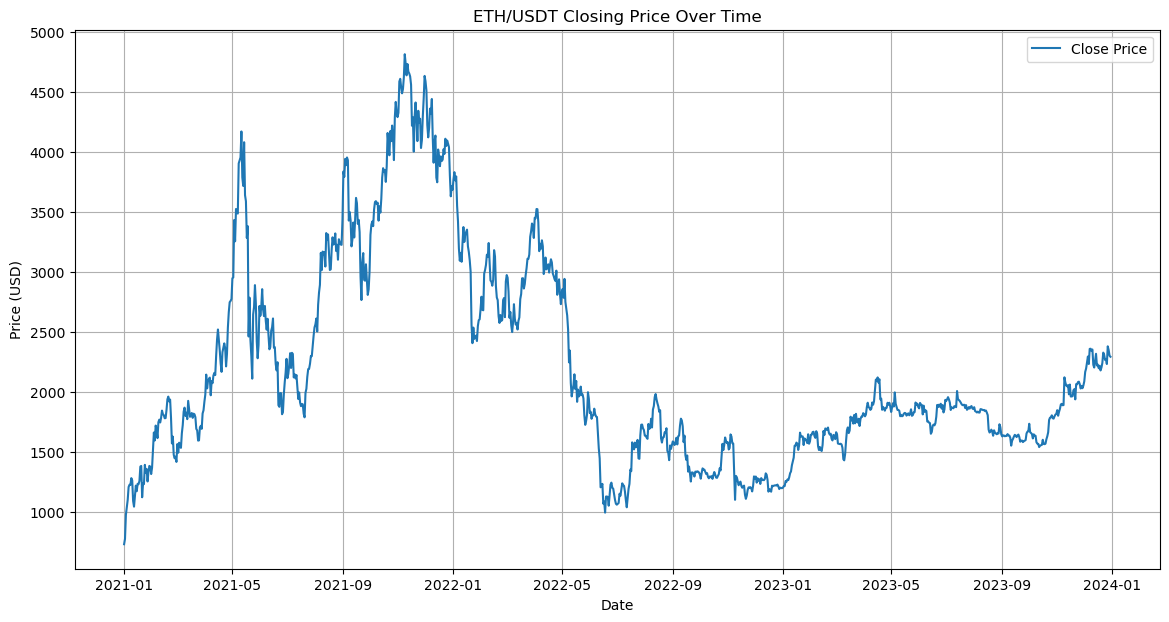

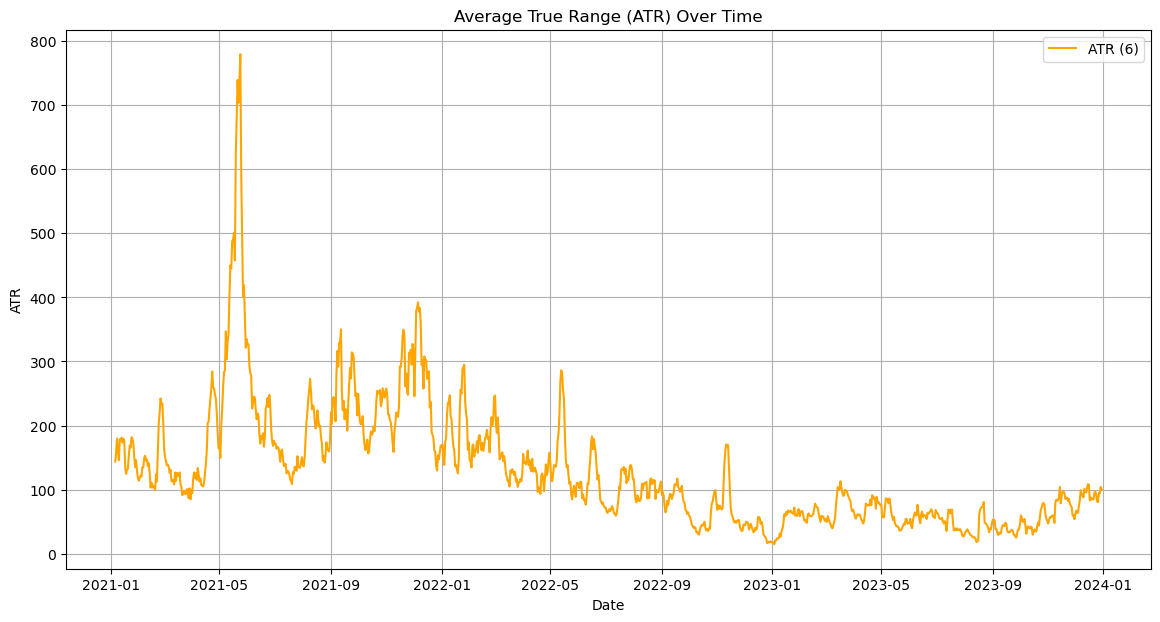

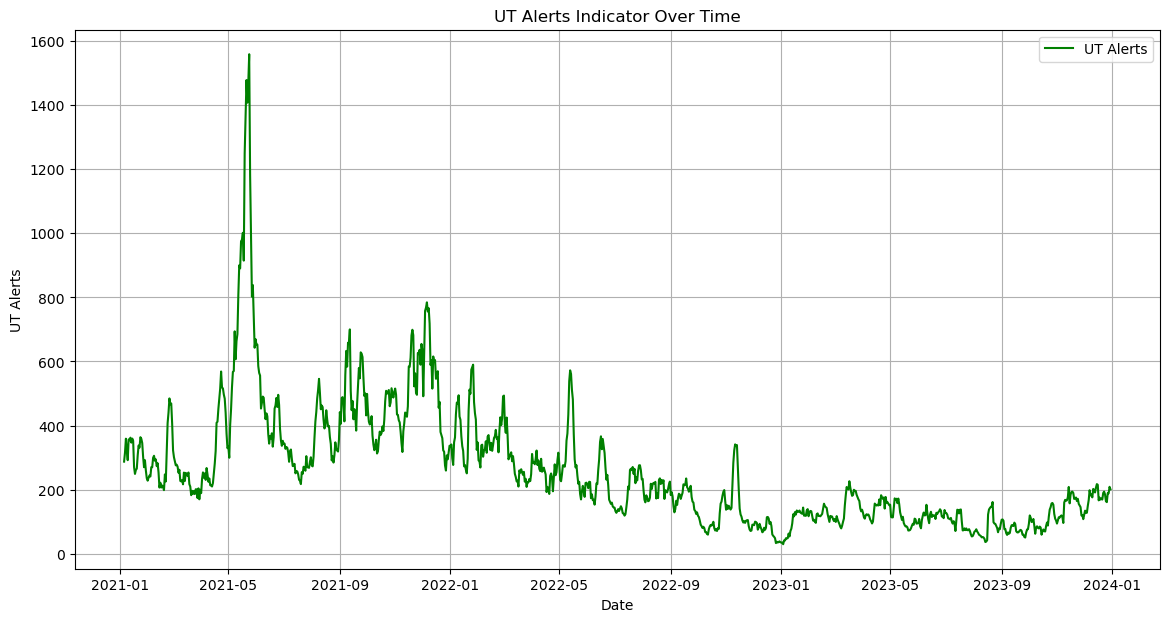

In [11]:
import matplotlib.pyplot as plt

# Plotting the closing price over time
plt.figure(figsize=(14, 7))
plt.plot(eth_usdt.index, eth_usdt['Close'], label='Close Price')
plt.title('ETH/USDT Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the ATR (Average True Range) over time
plt.figure(figsize=(14, 7))
plt.plot(eth_usdt.index, eth_usdt['ATR_6'], label='ATR (6)', color='orange')
plt.title('Average True Range (ATR) Over Time')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the UT Alerts indicator over time
plt.figure(figsize=(14, 7))
plt.plot(eth_usdt.index, eth_usdt['UT_Alerts'], label='UT Alerts', color='green')
plt.title('UT Alerts Indicator Over Time')
plt.xlabel('Date')
plt.ylabel('UT Alerts')
plt.legend()
plt.grid(True)
plt.show()
